In [62]:
from utils import *
from utils.GridWorldPitfalls import GridWorldWithPitfalls
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as func

# DQN (2013)
Deep Q-Network (DQN)<p>
DQN是Q-Learning的一个变体，其使用神经网络来预测和更新Q值，而不是像Q-Learning那样使用表格来存储Q值。<p>
这是Q-Learning的更新公式：$$ Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right] $$
其中目标值是$$ r + \gamma \max_{a'} Q(s',a') $$
而预测值为$$ Q(s, a) $$
那么显而易见的，我们可以得到error或者loss，即$$ TD\ Error = \delta = r + \gamma \max_{a'} Q(s',a') - Q(s,a) $$
此处 $ \alpha $ 就是神经网络的学习率<p>

### 首先定义一些参数

In [63]:
world_size = 16
n_actions = 4
batch_size = 32
deplayed_model_update_freq = 20
n_states = world_size * world_size
step_size = 1e-4
gamma = 0.8
win_states=[(12, 12)] 
fail_states=[(0, i) for i in range(8)] + [(i, 0) for i in range(8)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 定义神经网络
我们神经网络的输入应当是一个state，输出这个state对应的所有action的Q值<p>

In [64]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        # input: B x 1 x 16 x 16
        self.l1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)   # B x 16 x 8 x 8
        self.l2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)   # B x 32 x 4 x 4
        self.l3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # B x 64 x 2 x 2
        self.l4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # B x 128 x 2 x 2

        self.fc = nn.Linear(128 * 2 * 2, n_actions)

    def forward(self, x):
        x = func.leaky_relu(self.l1(x), inplace=True, negative_slope=0.1)
        x = func.leaky_relu(self.l2(x), inplace=True, negative_slope=0.1)
        x = func.leaky_relu(self.l3(x), inplace=True, negative_slope=0.1)
        x = func.leaky_relu(self.l4(x), inplace=True, negative_slope=0.1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### 定义训练用的函数与变量

In [65]:
def copyModel(src_model):
    dst_model = DQN().to(device)
    for src_param, dst_param in zip(src_model.parameters(), dst_model.parameters()):
        dst_param.data.copy_(src_param.data)
    dst_model.eval()
    return dst_model

grid_world = GridWorldWithPitfalls(world_size, win_states, fail_states)
dqn = DQN().to(device)
deplayed_dqn = copyModel(dqn)
loss_func = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(dqn.parameters(), lr=step_size)
replay_memory = []
replay_count = 0
replay_capacity = 10000

toTensor = lambda x: torch.tensor(x, dtype=torch.float32, device=device)
toNumpy = lambda x: x.detach().cpu().numpy()

def getStateTensor(state: int) -> torch.Tensor:
    state_tensor = toTensor(np.zeros((1, n_states)))
    state_tensor[0, state] = 1
    return state_tensor.view(1, 1, world_size, world_size)

def getActionTensor(action: int) -> torch.Tensor:
    action_tensor = toTensor(np.zeros((1, n_actions)))
    action_tensor[0, action] = 1
    return action_tensor

def takeAction(state: int, epsilon: float) -> int:
    """ Get an action at a given state following the current policy, with epsilon-greedy

    :param state: the given state
    :param epsilon: there is epsilon% chance of choosing a random action
    :return: the action to take
    """
    if np.random.random() < epsilon:
        return np.random.randint(n_actions)
    else:
        dqn.eval()
        with torch.no_grad():
            action_scores = dqn(getStateTensor(state))[0]
            # randomly take an action following the action-value distribution
            # action_scores -= action_scores.max()
            # action_scores /= action_scores.sum()
            # action_id = np.random.choice(np.arange(n_actions), p=toNumpy(action_scores))

            # take the maximum action
            action_id = action_scores.argmax().item()
        dqn.train()
        return action_id
    
def getTarget(state: int, action: int, reward: float, next_state: int, is_terminal: bool) -> torch.Tensor:
    """ Get the target value for the given state-action pair

    :param state: the given state
    :param action: the given action
    :param reward: the reward obtained after taking the action at the state
    :param next_state: the next state after taking the action at the state
    :param is_terminal: whether the next state is a terminal state
    :return: the target value
    """
    if is_terminal:
        return toTensor([reward])
    else:
        dqn.eval()
        with torch.no_grad():
            action_scores = dqn(getStateTensor(next_state))
            target = reward + gamma * action_scores[0].max()
        dqn.train()
        return toTensor([target])
    
def update(state: int, action: int, reward: float, next_state: int, is_terminal: bool) -> float:
    """ Update the Q-function using the given state-action pair

    :param state: the given state
    :param action: the given action
    :param reward: the reward obtained after taking the action at the state
    :param next_state: the next state after taking the action at the state
    :param is_terminal: whether the next state is a terminal state
    """
    optimizer.zero_grad()
    target = getTarget(state, action, reward, next_state, is_terminal)
    prediction = dqn(getStateTensor(state))[0, action]
    loss = loss_func(prediction, target)
    loss.backward()
    optimizer.step()
    return loss.item()


def batchUpdate():
    """ Update the Q-function using a batch of state-action pairs
    """
    optimizer.zero_grad()
    batch_indices = np.random.choice(replay_count, batch_size)
    batch = [replay_memory[i] for i in batch_indices]
    # get the batch data
    states, actions, rewards, next_states, is_terminals = zip(*batch)
    states = torch.cat(states, dim=0)  # B x 1 x world_size x world_size
    actions = torch.tensor(actions, dtype=torch.long, device=device)  # B (action_id)
    rewards = toTensor(rewards)     # B
    next_states = torch.cat(next_states, dim=0)    # B x 1 x world_size x world_size
    is_terminals = toTensor(is_terminals)

    # forward pass
    predictions = dqn(states).gather(1, actions.view(-1, 1)).squeeze()  # B
    # Note here deplayer_dqn is used to get the target value, this is fixed Q-targets
    targets = rewards + gamma * (1 - is_terminals) * deplayed_dqn(next_states).max(dim=1)[0]
    # backward pass
    loss = loss_func(predictions, targets)
    loss.backward()
    optimizer.step()
    return loss.item()

In [54]:
# agent = Agent(grid_world, Policy(grid_world))
# Make state value of terminal state
# agent.initTerminalValues(grid_world)

dqn.train()
pbar = tqdm(range(1000), desc="DQN")
for it in pbar:
    # initialize eposide with non terminal state
    grid_world.reset(world_size+1)
    while grid_world.isTerminalState(grid_world.start_sid):
        grid_world.reset(world_size+1)  # reset with a random start state

    old_sid = grid_world.current_sid

    while True:
        # random_action_id = np.random.randint(0, grid_world.n_actions)
        action_id = takeAction(old_sid, epsilon=0.4)
        r = grid_world.step(action_id)
        new_sid = grid_world.current_sid

        if grid_world.isTerminalState(grid_world.current_sid):
            ### --- Action value for terminal state --- ###
            loss = update(old_sid, action_id, r, new_sid, is_terminal=True)
            # agent.action_value[old_sid, action_id] += step_size * (r - agent.action_value[old_sid, action_id])
            break

        # update action value
        loss = update(old_sid, action_id, r, new_sid, is_terminal=False)
        # agent.action_value[old_sid, action_id] += step_size * (r + gamma * np.max(agent.action_value[new_sid]) - agent.action_value[old_sid, action_id])

        old_sid = new_sid
    if it % 100 == 0:
        pbar.set_postfix_str(f"loss={loss:.5f}")

DQN:   0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
DQN: 100%|██████████| 1000/1000 [01:36<00:00, 10.34it/s, loss=0.00416]


111 [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (4, 1), (5, 1), (4, 1), (5, 1), (4, 1), (5, 1), (4, 1), (5, 1), (4, 1), (5, 1), (4, 1), (5, 1), (4, 1), (5, 1), (4, 1), (5, 1), (4, 1), (5, 1), (4, 1), (4, 0)]


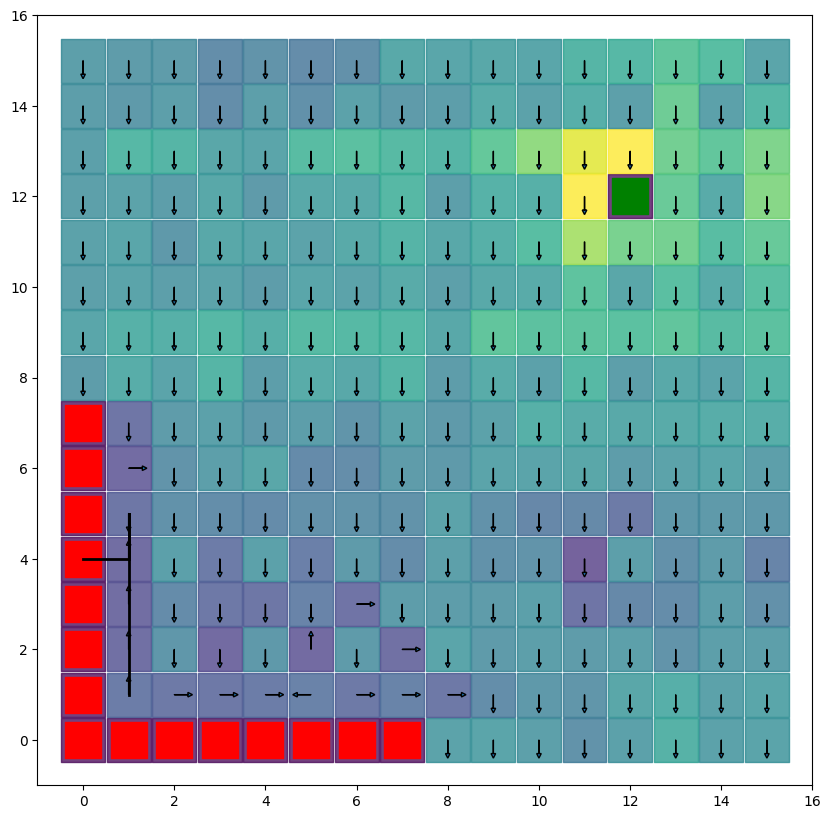

In [56]:
dqn.eval()
with torch.no_grad():
    agent = Agent(grid_world, Policy(grid_world))
    # setup agent policy and state value for visualization
    non_terminal_states = torch.cat([getStateTensor(sid) for sid in grid_world.getNonTerminalStateIds()], dim=0)
    all_action_scores = toNumpy(dqn(non_terminal_states))    # (n_non_terminal_states, n_actions)
    for i, sid in enumerate(grid_world.getNonTerminalStateIds()):
        action_scores = all_action_scores[i]
        best_action_id = action_scores.argmax()
        agent.policy[sid, best_action_id] = 1
        agent.state_value[sid] = np.max(action_scores)
    
    agent.policy.normalize()

    # Run another time to get path
    grid_world.reset(world_size+1)
    while not grid_world.isTerminalState(grid_world.current_sid):
        action_id = takeAction(grid_world.current_sid, epsilon=0.1)
        grid_world.step(action_id)

grid_world.render(agent, figsize=(10, 10))
plt.show()

根本就不收敛，收敛效果十分有限！只有terminal state附近的一些点才能收敛，拉闸，稀巴烂<p>

# Experience Replay and fixed Q-targets
DQN的一大问题就是每次计算Q值都是基于已有的Q值，然而Q值一致在不断变化，导致梯度下降的目标一直在波动，这样的话，神经网络的训练就会变得非常不稳定，因此我们需要一种方法来解决这个问题，那就是Experience Replay<p>
Experience Replay就是把曾经的数据都存起来，变成$(s_t, a_t, r, s_{t+1})$的格式，有了这几个数据就足够神经网络做一次梯度下降了。这样的另一个好处也是神经网络可以进行batch推理。要注意的是，虽然这个四元组是定死的，但由于网络一直在更新，因此每次更新参数都不一样<p>

In [66]:
# agent = Agent(grid_world, Policy(grid_world))
# Make state value of terminal state
# agent.initTerminalValues(grid_world)

dqn.train()
pbar = tqdm(range(1000), desc="DQN_2")
it = 0
for episode_i in pbar:
    # initialize eposide with non terminal state
    grid_world.reset(world_size+1)
    while grid_world.isTerminalState(grid_world.start_sid):
        grid_world.reset(world_size+1)  # reset with a random start state

    old_sid = grid_world.current_sid

    while True:
        # random_action_id = np.random.randint(0, grid_world.n_actions)
        action_id = takeAction(old_sid, epsilon=0.4)
        r = grid_world.step(action_id)
        new_sid = grid_world.current_sid

        # Store experience for replay
        if replay_count >= replay_capacity:
            replay_memory.pop(0)
            replay_count -= 1
        replay_memory.append((getStateTensor(old_sid), action_id, r, getStateTensor(new_sid), grid_world.isTerminalState(grid_world.current_sid)))
        replay_count += 1

        loss = batchUpdate()

        if grid_world.isTerminalState(grid_world.current_sid):
            break

        old_sid = new_sid

        it += 1
        if it % deplayed_model_update_freq == 0:
            deplayed_dqn = copyModel(dqn)

    if episode_i % 100 == 0:
        pbar.set_postfix_str(f"loss={loss:.5f}")

DQN_2: 100%|██████████| 1000/1000 [01:24<00:00, 11.80it/s, loss=0.00009]


111 [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (0, 12), (15, 12), (14, 12), (13, 12), (12, 12)]


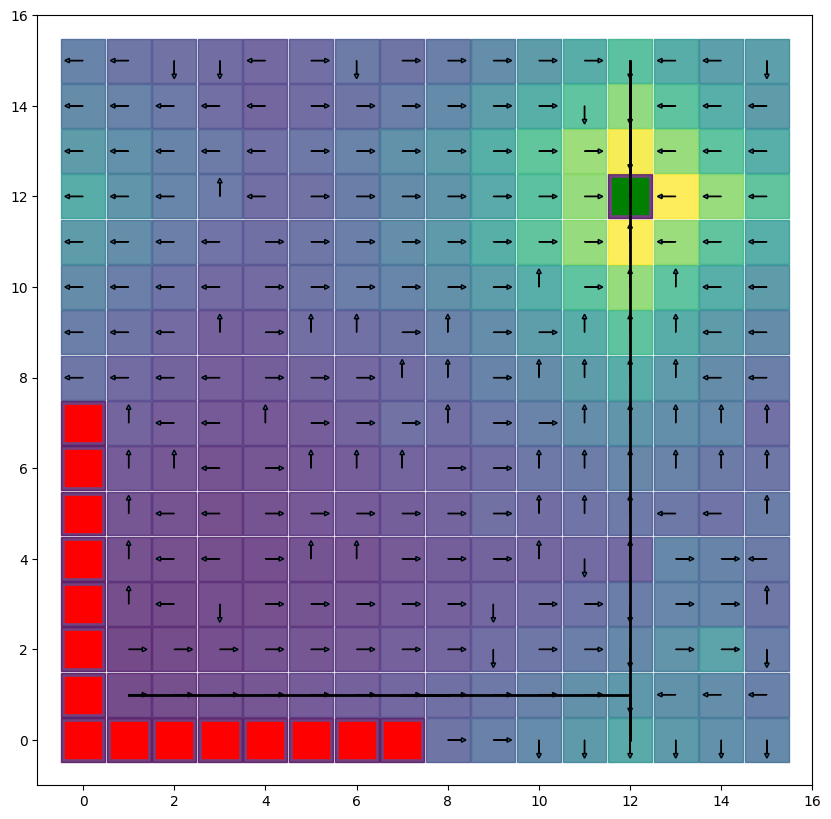

In [67]:
dqn.eval()
with torch.no_grad():
    agent = Agent(grid_world, Policy(grid_world))
    # setup agent policy and state value for visualization
    non_terminal_states = torch.cat([getStateTensor(sid) for sid in grid_world.getNonTerminalStateIds()], dim=0)
    all_action_scores = toNumpy(dqn(non_terminal_states))    # (n_non_terminal_states, n_actions)
    for i, sid in enumerate(grid_world.getNonTerminalStateIds()):
        action_scores = all_action_scores[i]
        best_action_id = action_scores.argmax()
        agent.policy[sid, best_action_id] = 1
        agent.state_value[sid] = np.max(action_scores)
    
    agent.policy.normalize()

    # Run another time to get path
    grid_world.reset(world_size+1)
    while not grid_world.isTerminalState(grid_world.current_sid):
        action_id = takeAction(grid_world.current_sid, epsilon=0.1)
        grid_world.step(action_id)

grid_world.render(agent, figsize=(10, 10))
plt.show()

这下还行，看来真的得用experience replay和fixed Q-targets，真聪明啊研究出这个东西的人，哈哈哈哈哈哈<p>